## Importamos la librerias (Necesario tener instalado Vizdoom)

In [1]:
import tensorflow as tf      # Deep Learning library
import numpy as np          
from vizdoom import *        # Doom Environment

import random                
import time                  
from skimage import transform

from collections import deque  #se usa en el buffer de memoria
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore') 

C:\Anaconda\envs\vizdoom-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



### Entorno (Basic)
    -3 acciones posibles (Derecha, Centro, Izquierda)

Recompensas:
- +101 por matar
- -5 por disparar el arma
- Episodio acaba cuando hay timeout o matamos al monstruo
- por estar vivos le quitamos 1, asi conseguimos que lo intente matar lo antes posible

In [2]:
"""
Here we create our environment
"""
def create_environment():
    game = DoomGame()
    
    game.load_config("basic.cfg")
    
    game.set_doom_scenario_path("basic.wad")
    
    # Here our possible actions
    left = [1, 0, 0]
    right = [0, 1, 0]
    shoot = [0, 0, 1]
    possible_actions = [left, right, shoot]
    
    return game, possible_actions
       
"""
Here we performing random action to test the environment
"""
def test_environment():
    game = DoomGame()
    game.load_config("basic.cfg")
    game.set_doom_scenario_path("basic.wad")
    game.init()
    shoot = [0, 0, 1]
    left = [1, 0, 0]
    right = [0, 1, 0]
    actions = [shoot, left, right]

    episodes = 100
    for i in range(episodes):
        game.new_episode()
        while not game.is_episode_finished():
            state = game.get_state()
            img = state.screen_buffer
            misc = state.game_variables
            action = random.choice(actions)
            print(action)
            reward = game.make_action(action)
            time.sleep(0.02)
        print ("Result:", game.get_total_reward())
        time.sleep(1)
    game.close()

In [3]:
game,possible_actions = create_environment()

In [4]:
#test_environment()

## Preprocesamos los frames para reducir la complejidad

- Los pasamos a gris, ya qu la información del color no es importante.
- Recortamos los frames para quitar la parte no importante
- Reescalamos los frames

In [5]:

def preprocess_frame(frame):
    #Estos valores los he ido modificando hasta dejar el frame como yo queria, lo he comprobado usando el plotter en la siguiente celda
    cropped_frame = frame[30:-10,30:-30]
    
    # Hacemos uniformes los valores para que no haya grandes desviaciones
    normalized_frame = cropped_frame/255.0
    
    # Reescalamos
    preprocessed_frame = transform.resize(normalized_frame, [84,84])
    
    return preprocessed_frame

### stack_frames
👏 This part was made possible thanks to help of <a href="https://github.com/Miffyli">Anssi</a><br>

As explained in this really <a href="https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/">  good article </a> we stack frames.

Stacking frames is really important because it helps us to **give have a sense of motion to our Neural Network.**

- First we preprocess frame
- Then we append the frame to the deque that automatically **removes the oldest frame**
- Finally we **build the stacked state**

This is how work stack:
- For the first frame, we feed 4 frames
- At each timestep, **we add the new frame to deque and then we stack them to form a new stacked frame**
- And so on
<img src="https://raw.githubusercontent.com/simoninithomas/Deep_reinforcement_learning_Course/master/DQN/Space%20Invaders/assets/stack_frames.png" alt="stack">
- If we're done, **we create a new stack with 4 new frames (because we are in a new episode)**.

In [6]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4) 

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((84,84), dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

## Step 4: Set up our hyperparameters ⚗️
In this part we'll set up our different hyperparameters. But when you implement a Neural Network by yourself you will **not implement hyperparamaters at once but progressively**.

- First, you begin by defining the neural networks hyperparameters when you implement the model.
- Then, you'll add the training hyperparameters when you implement the training algorithm.

In [7]:
### MODEL HYPERPARAMETERS
state_size = [84,84,4]      # Our input is a stack of 4 frames hence 84x84x4 (Width, height, channels) 
action_size = game.get_available_buttons_size()              # 3 possible actions: left, right, shoot
learning_rate =  0.00025     # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 600      # Total episodes for training
max_steps = 200             # Max possible steps in an episode
batch_size = 80             

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.00001            # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.95               # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = True

## NUESTRA DEEP Q NETWORK
This is our Deep Q-learning model:
- INPUT: 4 FRAMES DE 84X84
- PASA POR 3 REDES CONVOLUCIONALES, REDUCIENDO EL NUMERO DE FILTROS
- APLANAMOS PARA TENER UN VECTOR DE RESULTADOS
- PASAMOS ESTE VECTOR DE RESULTADOS POR CAPAS CONECTADAS PARA PODER TENER ACTIVACIONES EN FUNCION DE CADA ESTADO
- SACA UN VALOR Q PARA CADA UNA DE LAS 3 ACCIONES

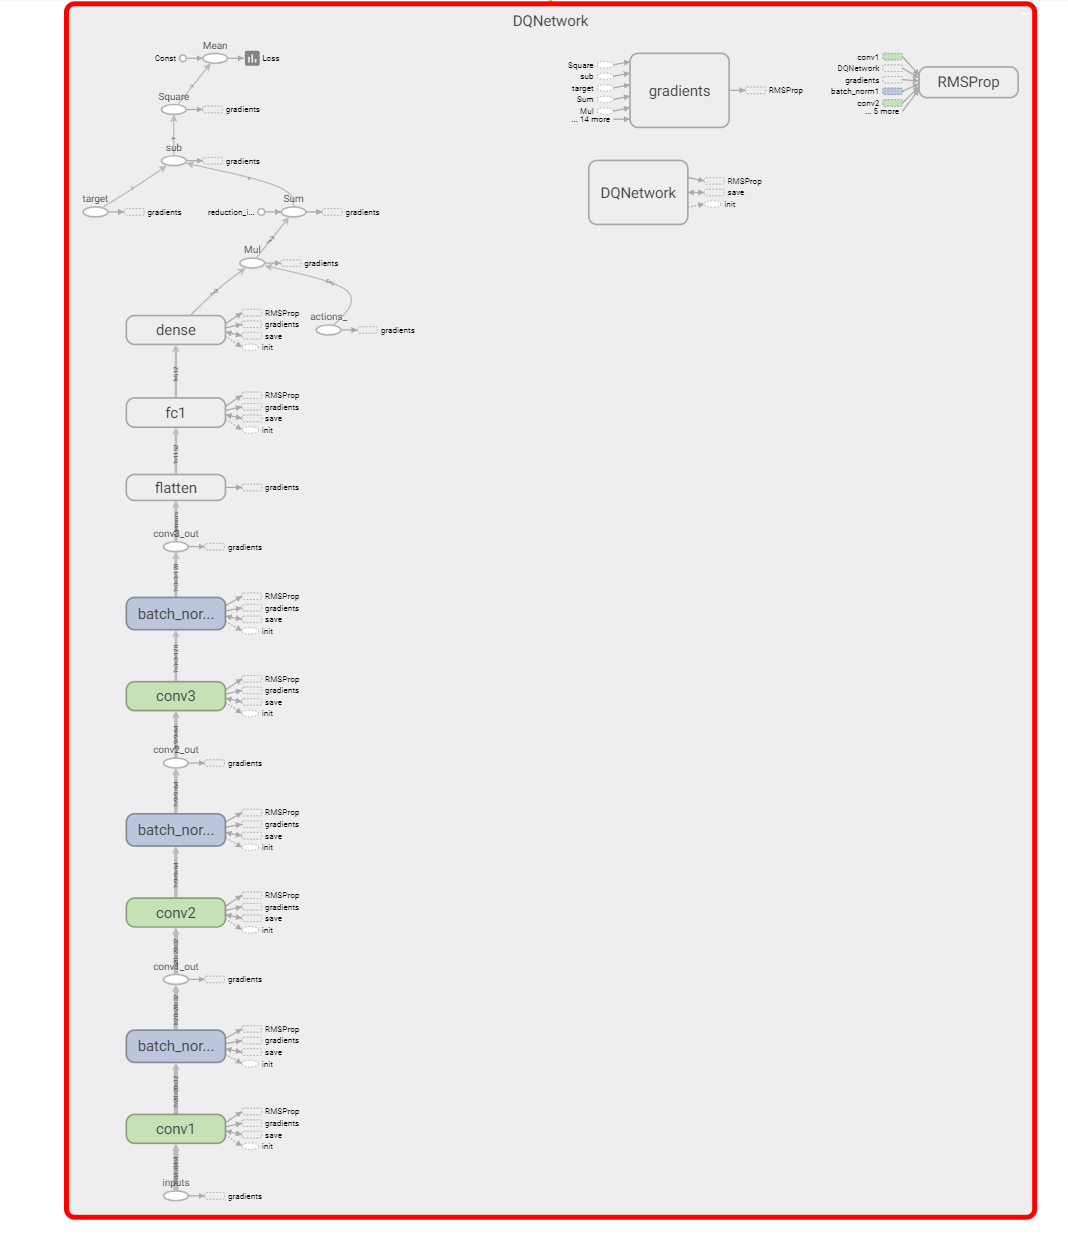

In [8]:
class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, 3], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            """
            First convnet:
            CNN
            BatchNormalization
            ELU
            """
            # Input is 84x84x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            
            self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm1')
            
            self.conv1_out = tf.nn.elu(self.conv1_batchnorm, name="conv1_out")
            ## --> [20, 20, 32]
            
            
            """
            Second convnet:
            CNN
            BatchNormalization
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")
        
            self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm2')

            self.conv2_out = tf.nn.elu(self.conv2_batchnorm, name="conv2_out")
            ## --> [9, 9, 64]
            
            
            """
            Third convnet:
            CNN
            BatchNormalization
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 128,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")
        
            self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm3')

            self.conv3_out = tf.nn.elu(self.conv3_batchnorm, name="conv3_out")
            ## --> [3, 3, 128]
            
            
            self.flatten = tf.layers.flatten(self.conv3_out)
            ## --> [1152]
            
            
            self.fc = tf.layers.dense(inputs = self.flatten,
                                  units = 512,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc1")
            
            
            self.output = tf.layers.dense(inputs = self.fc, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          units = 3, 
                                        activation=None)

  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis=1)
            
            
            # PARA CALCULAR LA PERDIDA USAMOS LOS ERRORES CUADRADOS, ESTE METODO DA MAS PRIORIDAD A LAS RESTAS GRANDES, INTENTANDO
            # PRIORIZAR ESAS
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)

In [9]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DQNetwork(state_size, action_size, learning_rate)

## Step 6: Experience Replay 🔁
Now that we create our Neural Network, **we need to implement the Experience Replay method.** <br><br>
Here we'll create the Memory object that creates a deque.A deque (double ended queue) is a data type that **removes the oldest element each time that you add a new element.**

This part was taken from Udacity : <a href="https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb" Cartpole DQN</a>

In [10]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

Here we'll **deal with the empty memory problem**: we pre-populate our memory by taking random actions and storing the experience (state, action, reward, new_state).

In [11]:
# Instantiate memory
memory = Memory(max_size = memory_size)


game.init()
# Render the environment
game.new_episode()

for i in range(pretrain_length):
    # If it's the first step
    if i == 0:
        # First we need a state
        state = game.get_state().screen_buffer
        state, stacked_frames = stack_frames(stacked_frames, state, True)
    
    # Random action
    action = random.choice(possible_actions)
    
    # Get the rewards
    reward = game.make_action(action)
    
    # Look if the episode is finished
    done = game.is_episode_finished()
    
    # If we're dead
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Start a new episode
        game.new_episode()
        
        # First we need a state
        state = game.get_state().screen_buffer
        
        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    else:
        # Get the next state
        next_state = game.get_state().screen_buffer
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Our state is now the next_state
        state = next_state



## SEGUIMIENTO DEL ALGORITMO
Para ver tensorboard:
    - Ejecutar anaconda Prompt con un entorno que tenga instalado tensorboard
    - escribir tensorboard --logdir="./tensorboard/vizdoom_basic_dqn"
    - Comprobar la funcion de coste, con este algoritmo converge hacia las 300 iteraciones

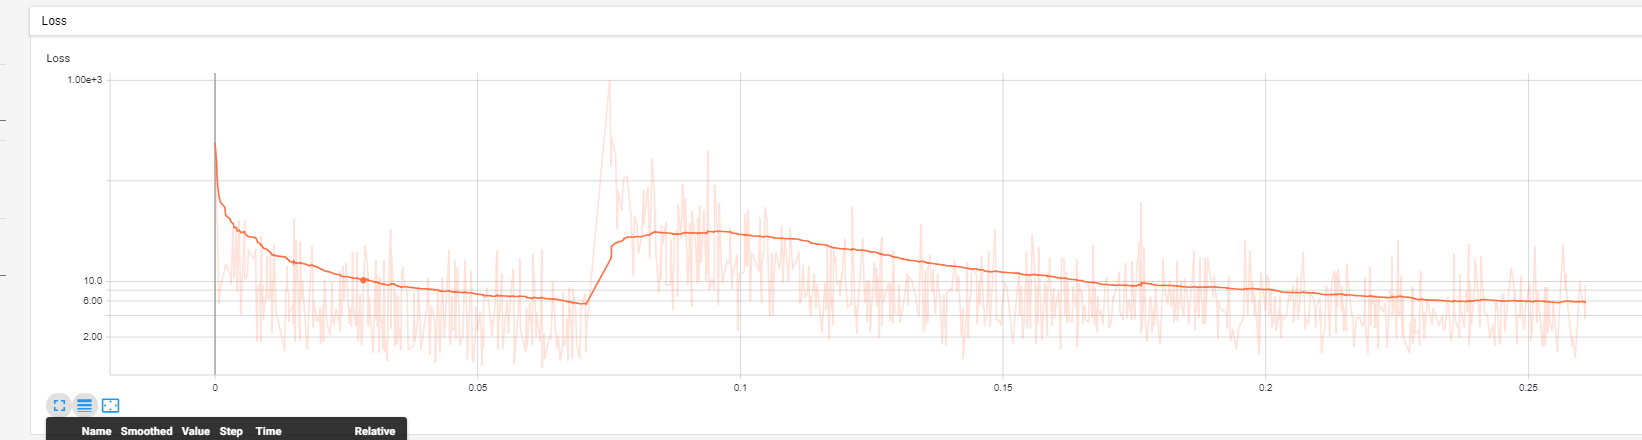


In [12]:
# Setup TensorBoard Writer
writer = tf.summary.FileWriter("./tensorboard/vizdoom_basic_dqn")

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.summary.merge_all()

## ALGORITMO DQN
<br>
* Initialize the weights, WITH RANDOM WEIGHTS SO WE CAN HAVE GRADIENTS. THE GRADIENT OF 0 IS 0. WE WOULD END UP WITH A DEAD NN.
* Init the environment
* Initialize the decay rate (that will use to reduce epsilon), SO WE CAN EXPLORE OTHER OPTIONS WHILE TRAINING
<br><br>
* **For** episode to max_episode **do** 
    * Make new episode
    * Set step to 0
    * Observe the first state $s_0$
    <br><br>
    * **While** step < max_steps **do**:
        * Increase decay_rate
        * With $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
        * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
        * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
        * Sample random mini-batch from $D$: $<s, a, r, s'>$
        * Set $\hat{Q} = r$ if the episode ends at $+1$, otherwise set $\hat{Q} = r + \gamma \max_{a'}{Q(s', a')}$
        * Make a gradient descent step with loss $(\hat{Q} - Q(s, a))^2$
    * **endfor**
    <br><br>
* **endfor**

    

In [13]:
"""
This function will do the part
With ϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        action = random.choice(possible_actions)
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[int(choice)]
                
    return action, explore_probability

In [14]:
# Saver will help us to save our model
saver = tf.train.Saver(save_relative_paths=True)

if training == True:
    with tf.Session() as sess:
        # Initialize the variables
        sess.run(tf.global_variables_initializer())
        writer.add_graph(sess.graph)
        
        
        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0

        # Init the game
        game.init()

        for episode in range(total_episodes):
            # Set step to 0
            step = 0
            
            # Initialize the rewards of the episode
            episode_rewards = []
            
            # Make a new episode and observe the first state
            game.new_episode()
            state = game.get_state().screen_buffer
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)

            while step < max_steps:
                step += 1
                
                # Increase decay_step
                decay_step +=1
                
                # Predict the action to take and take it
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)

                # Do the action
                reward = game.make_action(action)

                # Look if the episode is finished
                done = game.is_episode_finished()
                
                # Add the reward to total reward
                episode_rewards.append(reward)

                # If the game is finished
                if done:
                    # the episode ends so no next state
                    next_state = np.zeros((84,84), dtype=np.int)
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)

                    print('Episode: {}'.format(episode),
                              'Total reward: {}'.format(total_reward),
                              'Training loss: {:.4f}'.format(loss),
                              'Explore P: {:.4f}'.format(explore_probability))

                    memory.add((state, action, reward, next_state, done))

                else:
                    # Get the next state
                    next_state = game.get_state().screen_buffer
                    
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    

                    # Add experience to memory
                    memory.add((state, action, reward, next_state, done))
                    
                    # st+1 is now our current state
                    state = next_state


                ### LEARNING PART            
                # Obtain random mini-batch from memory
                batch = memory.sample(batch_size)
                states_mb = np.array([each[0] for each in batch], ndmin=3)
                actions_mb = np.array([each[1] for each in batch])
                rewards_mb = np.array([each[2] for each in batch]) 
                next_states_mb = np.array([each[3] for each in batch], ndmin=3)
                dones_mb = np.array([each[4] for each in batch])

                target_Qs_batch = []

                 # Get Q values for next_state 
                Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])

                loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                    feed_dict={DQNetwork.inputs_: states_mb,
                                               DQNetwork.target_Q: targets_mb,
                                               DQNetwork.actions_: actions_mb})

                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb})
                writer.add_summary(summary, episode)
                writer.flush()

            # Save model every 5 episodes
            if episode % 5 == 0:
                save_path = saver.save(sess, "/models/dqn/vizdoom_basic")
                print("Model Saved")

Episode: 0 Total reward: -94.0 Training loss: 4.9304 Explore P: 0.9985
Model Saved
Episode: 1 Total reward: 95.0 Training loss: 20.1472 Explore P: 0.9984
Episode: 3 Total reward: 63.0 Training loss: 9.2692 Explore P: 0.9961
Episode: 4 Total reward: 71.0 Training loss: 32.0545 Explore P: 0.9959
Episode: 5 Total reward: 92.0 Training loss: 7.7089 Explore P: 0.9958
Model Saved
Model Saved
Episode: 11 Total reward: 67.0 Training loss: 2.0302 Explore P: 0.9857
Episode: 13 Total reward: 12.0 Training loss: 2.0868 Explore P: 0.9830
Episode: 14 Total reward: 92.0 Training loss: 47.2814 Explore P: 0.9829
Episode: 15 Total reward: 49.0 Training loss: 10.2030 Explore P: 0.9825
Model Saved
Episode: 16 Total reward: 46.0 Training loss: 4.8853 Explore P: 0.9821
Episode: 17 Total reward: 94.0 Training loss: 14.5741 Explore P: 0.9820
Model Saved
Episode: 21 Total reward: 95.0 Training loss: 2.7526 Explore P: 0.9761
Episode: 22 Total reward: -130.0 Training loss: 3.6696 Explore P: 0.9743
Episode: 25 To

Model Saved
Episode: 146 Total reward: 92.0 Training loss: 3.1078 Explore P: 0.8918
Episode: 147 Total reward: 95.0 Training loss: 4.7247 Explore P: 0.8917
Episode: 148 Total reward: 93.0 Training loss: 4.1442 Explore P: 0.8916
Episode: 149 Total reward: -20.0 Training loss: 5.6030 Explore P: 0.8908
Episode: 150 Total reward: -115.0 Training loss: 2.8629 Explore P: 0.8892
Model Saved
Episode: 151 Total reward: 94.0 Training loss: 14.9216 Explore P: 0.8892
Episode: 153 Total reward: 95.0 Training loss: 3.4346 Explore P: 0.8874
Episode: 154 Total reward: 94.0 Training loss: 4.9186 Explore P: 0.8873
Episode: 155 Total reward: 41.0 Training loss: 4.2509 Explore P: 0.8869
Model Saved
Episode: 156 Total reward: 95.0 Training loss: 4.5229 Explore P: 0.8868
Episode: 157 Total reward: 95.0 Training loss: 5.1989 Explore P: 0.8868
Episode: 158 Total reward: 92.0 Training loss: 11.0341 Explore P: 0.8867
Episode: 159 Total reward: 91.0 Training loss: 6.5679 Explore P: 0.8866
Episode: 160 Total rewa

Episode: 265 Total reward: -34.0 Training loss: 5.6056 Explore P: 0.8403
Model Saved
Episode: 266 Total reward: 73.0 Training loss: 5.4747 Explore P: 0.8401
Episode: 267 Total reward: 95.0 Training loss: 5.2216 Explore P: 0.8401
Episode: 268 Total reward: 83.0 Training loss: 6.9915 Explore P: 0.8399
Episode: 269 Total reward: 95.0 Training loss: 3.4359 Explore P: 0.8399
Episode: 270 Total reward: 92.0 Training loss: 6.2253 Explore P: 0.8398
Model Saved
Episode: 271 Total reward: -44.0 Training loss: 24.3405 Explore P: 0.8388
Episode: 272 Total reward: 95.0 Training loss: 4.1538 Explore P: 0.8388
Episode: 273 Total reward: -34.0 Training loss: 8.1741 Explore P: 0.8379
Episode: 274 Total reward: 18.0 Training loss: 20.9673 Explore P: 0.8373
Episode: 275 Total reward: 95.0 Training loss: 5.3893 Explore P: 0.8373
Model Saved
Episode: 276 Total reward: 94.0 Training loss: 3.4344 Explore P: 0.8372
Episode: 277 Total reward: 93.0 Training loss: 4.7404 Explore P: 0.8371
Episode: 279 Total rewa

Model Saved
Episode: 381 Total reward: 95.0 Training loss: 4.5183 Explore P: 0.7939
Episode: 382 Total reward: 94.0 Training loss: 4.3340 Explore P: 0.7938
Episode: 383 Total reward: -1.0 Training loss: 3.6663 Explore P: 0.7932
Episode: 384 Total reward: 92.0 Training loss: 6.5494 Explore P: 0.7931
Episode: 385 Total reward: 48.0 Training loss: 3.7712 Explore P: 0.7928
Model Saved
Episode: 386 Total reward: 95.0 Training loss: 6.9865 Explore P: 0.7927
Episode: 387 Total reward: 29.0 Training loss: 2.4035 Explore P: 0.7923
Episode: 388 Total reward: 94.0 Training loss: 2.2825 Explore P: 0.7922
Episode: 389 Total reward: 92.0 Training loss: 6.9172 Explore P: 0.7922
Episode: 390 Total reward: -90.0 Training loss: 3.0738 Explore P: 0.7909
Model Saved
Episode: 391 Total reward: 23.0 Training loss: 3.8985 Explore P: 0.7905
Episode: 392 Total reward: 93.0 Training loss: 6.7410 Explore P: 0.7904
Episode: 393 Total reward: -102.0 Training loss: 2.8028 Explore P: 0.7892
Episode: 394 Total reward

Episode: 495 Total reward: 94.0 Training loss: 3.6810 Explore P: 0.7541
Model Saved
Episode: 496 Total reward: -34.0 Training loss: 4.0287 Explore P: 0.7533
Episode: 497 Total reward: 95.0 Training loss: 5.8122 Explore P: 0.7532
Episode: 498 Total reward: 24.0 Training loss: 3.5670 Explore P: 0.7528
Episode: 499 Total reward: -31.0 Training loss: 3.9871 Explore P: 0.7520
Episode: 500 Total reward: 43.0 Training loss: 5.1387 Explore P: 0.7516
Model Saved
Episode: 502 Total reward: 67.0 Training loss: 4.2787 Explore P: 0.7499
Episode: 503 Total reward: 95.0 Training loss: 4.8009 Explore P: 0.7499
Episode: 504 Total reward: -15.0 Training loss: 2.5646 Explore P: 0.7492
Episode: 505 Total reward: 95.0 Training loss: 2.9442 Explore P: 0.7491
Model Saved
Episode: 506 Total reward: 91.0 Training loss: 4.6166 Explore P: 0.7490
Episode: 507 Total reward: 95.0 Training loss: 4.0636 Explore P: 0.7490
Episode: 508 Total reward: 67.0 Training loss: 2.7943 Explore P: 0.7488
Episode: 509 Total reward

## Step 9: Watch our Agent play 👀
Now that we trained our agent, we can test it

In [15]:

with tf.Session() as sess:
    
    game.init()
    
    totalScore = 0
    
   
    # Load the model
    saver = tf.train.import_meta_graph("/models/dqn/vizdoom_basic.meta")
    saver.restore(sess, tf.train.latest_checkpoint("/models/dqn"))
                  
    for i in range(20):
        game.new_episode()
        while not game.is_episode_finished():
            frame = game.get_state().screen_buffer
            state,_ = stack_frames(stacked_frames, frame,False)
            # Take the biggest Q value (= the best action)
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
            action = np.argmax(Qs)
            action = possible_actions[int(action)]
            game.make_action(action)        
            score = game.get_total_reward()
            time.sleep(0.05)
        print("Score: " + str(score) + " at episode: " + str(i))
        totalScore += score
        time.sleep(1)
    #la puntuacion maxima posible es de 101 si eliminamos al monstruo en el primer tick
    print("AVERAGE_SCORE: "+ str((totalScore/20)))
    game.close()

INFO:tensorflow:Restoring parameters from /models/dqn\vizdoom_basic
Score: 94.0 at episode: 0
Score: 93.0 at episode: 1
Score: 68.0 at episode: 2
Score: 93.0 at episode: 3
Score: 49.0 at episode: 4
Score: 92.0 at episode: 5
Score: 93.0 at episode: 6
Score: 41.0 at episode: 7
Score: 93.0 at episode: 8
Score: 95.0 at episode: 9
Score: -3.0 at episode: 10
Score: 93.0 at episode: 11
Score: 72.0 at episode: 12
Score: 85.0 at episode: 13
Score: 94.0 at episode: 14
Score: 93.0 at episode: 15
Score: 95.0 at episode: 16
Score: 92.0 at episode: 17
Score: 93.0 at episode: 18
Score: 93.0 at episode: 19
AVERAGE_SCORE: 80.9
